This notebook is used to create a supplemental figure that counts the number of donors per each cell type. 

Environment: preprocess_and_plot_umaps_env


In [1]:
import os
import sys
import numpy as np
import anndata
from matplotlib import pyplot as plt

# ---- Add Parent Directory to Path ----
sys.path.append("../")  # Now you can import from the parent directory

from paths_config import data_base_path, outputs_path, scenario_id
from scMEDAL.utils.utils import read_adata

# ---- Define Data Paths ----
parent_path = os.path.join(data_base_path, "adata_merged")

# ---- Read AnnData ----
X, var, obs = read_adata(folder_path=parent_path)
adata = anndata.AnnData(X=X, obs=obs, var=var)

# ---- Convert 'nan' to String ----
adata.obs["CellType"] = adata.obs["CellType"].astype("str")

# ---- Filter Cells ----
# Van Galen et al. 2019 randomly filtered 783 cells of 1,590 BM5 CD34+CD38- cells to reduce representation of this population
# Condition 1: Exclude 'nan' cells
keep_cells_condition1 = adata.obs["CellType"] != "nan"

# Dai et al. 2021 excludes AML314, AML371, AML722B, and AML997 samples due to unconfident annotations
# https://www.frontiersin.org/articles/10.3389/fcell.2021.762260/full
# Condition 2: Exclude specific IDs
exclude_ids = ["AML314", "AML371", "AML722B", "AML997"]
keep_cells_condition2 = ~adata.obs["id"].isin(exclude_ids)

# Combine both conditions using logical AND (&)
keep_cells_combined_condition = keep_cells_condition1 & keep_cells_condition2

# Apply the combined condition to filter `adata` directly
filtered_adata = adata[keep_cells_combined_condition, :].copy()

print(f"Original number of cells: {adata.X.shape[0]}")
print(f"Number of cells after filtering: {filtered_adata.X.shape[0]}")
print("adata before preprocessing:", filtered_adata)

# ---- Rename Columns for Clarity ----
filtered_adata.obs["celltype"] = filtered_adata.obs["CellType"]
filtered_adata.obs["batch"] = filtered_adata.obs["id"]

data_base_path: /endosome/archive/bioinformatics/DLLab/src/AixaAndrade/gitfront/scMEDAL_for_scRNAseq/Experiments/AML/../data/AML_data
outputs_path: /endosome/archive/bioinformatics/DLLab/src/AixaAndrade/gitfront/scMEDAL_for_scRNAseq/Experiments/AML/../outputs/AML_outputs
Reading data from: /endosome/archive/bioinformatics/DLLab/src/AixaAndrade/gitfront/scMEDAL_for_scRNAseq/Experiments/AML/../data/AML_data/adata_merged


/archive/bioinformatics/DLLab/shared/CondaEnvironments/Aixa_scDML/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Original number of cells: 41090
Number of cells after filtering: 38417
adata before preprocessing: AnnData object with n_obs × n_vars = 38417 × 27899
    obs: 'Unnamed: 0', 'Cell', 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'PredictionRefined', 'CellType', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'NanoporeTranscripts', 'id', 'Day', 'unique_id', 'Patient_group'
    var: 'Unnamed: 0', 'Gene'


In [2]:
len(np.unique(filtered_adata.obs["batch"]))

19

In [3]:
len(np.unique(filtered_adata.obs["celltype"]))

21

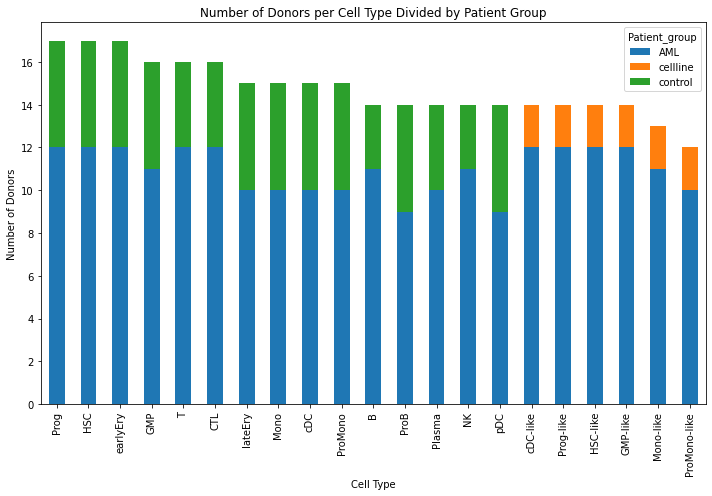

In [28]:
# Create Supplemental figure

# Counting the number of unique donors (batches) per cell type divided by patient group
donors_per_celltype_group = filtered_adata.obs.groupby(['celltype', 'Patient_group'])['batch'].nunique().unstack(fill_value=0)
# Sorting the data by total number of donors across all patient groups
donors_per_celltype_group['Total'] = donors_per_celltype_group.sum(axis=1)
donors_per_celltype_group_sorted = donors_per_celltype_group.sort_values(by='Total', ascending=False).drop(columns='Total')
# Sorting first by the absence of 'like' (False), then by the total number of donors
donors_per_celltype_group_sorted['Has_like'] = donors_per_celltype_group_sorted.index.str.contains('like', case=False)
donors_per_celltype_group_sorted['Total'] = donors_per_celltype_group_sorted.sum(axis=1)

donors_per_celltype_group_sorted = donors_per_celltype_group_sorted.sort_values(by=['Has_like', 'Total'], ascending=[True, False])

# Dropping the helper columns used for sorting before plotting
donors_per_celltype_group_sorted = donors_per_celltype_group_sorted.drop(columns=['Has_like', 'Total'])
fig, ax = plt.subplots(figsize=(10, 7))
# Plotting the sorted data with numbers on top of each bar for each patient group
donors_per_celltype_group_sorted.plot(kind='bar', stacked=True, figsize=(10, 7),ax=ax)
plt.xlabel('Cell Type')
plt.ylabel('Number of Donors')
plt.title('Number of Donors per Cell Type Divided by Patient Group')

plt.tight_layout()
plt.show()
# 'path_to_figures'
# Define the path to the output directories
fig_out_path = os.path.join(outputs_path, "figures", scenario_id, "Supplemental")

# Check and create directories if they do not exist
os.makedirs(fig_out_path, exist_ok=True)

# Save the figure
fig.savefig(os.path.join(fig_out_path, "donors_per_celltype.png"))